In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F

# Transformasi dengan augmentasi data
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Flip horizontal secara acak
    transforms.RandomCrop(32, padding=4),  # Crop acak dengan padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Perubahan warna
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalisasi
])

In [3]:
# Download dataset CIFAR-10 dengan transformasi
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ]))


Files already downloaded and verified
Files already downloaded and verified


In [11]:
# Membatasi dataset ke 10.000 sampel
subset_size = 10000
indices = list(range(subset_size))
trainset_subset = Subset(trainset, indices)

# Membuat DataLoader menggunakan subset
trainloader = DataLoader(trainset_subset, batch_size=32, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)


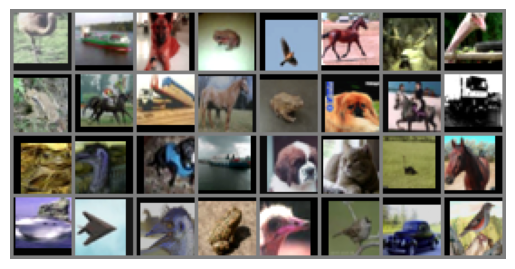

bird  ship  dog   frog  bird  horse deer  bird  frog  horse truck horse frog  dog   horse truck frog  bird  dog   ship  dog   cat   bird  horse ship  airplane bird  frog  bird  bird  automobile bird 


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Fungsi untuk menampilkan gambar
def imshow(img):
    img = img / 2 + 0.5  # Denormalisasi gambar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Menghilangkan sumbu
    plt.show()

# Mendapatkan nama-nama kelas dari dataset CIFAR-10
classes = trainset.classes

# Mendapatkan batch gambar dari trainloader
dataiter = iter(trainloader)
images, labels = next(dataiter)  # Menggunakan fungsi built-in next()

# Menampilkan gambar beserta labelnya
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(len(labels))))


In [22]:
# Mendefinisikan model CNN sederhana
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instansiasi model, loss function, dan optimizer
model = SimpleCNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Untuk menyimpan loss dan akurasi setiap epoch
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
num_epochs = 20

# Training phase
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    # Training
    model.train()
    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Rata-rata loss dan akurasi di akhir epoch
    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Evaluation phase
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []  # List untuk menyimpan semua prediksi
    all_labels = []  # List untuk menyimpan semua label

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())  # Menyimpan prediksi
            all_labels.extend(labels.cpu().numpy())    # Menyimpan label asli

    # Rata-rata loss dan akurasi di akhir epoch untuk test set
    test_loss = running_loss / len(testloader)
    test_accuracy = 100 * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'Testing - Epoch [{epoch+1}/{num_epochs}], Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%')

# Menggambar grafik loss dan akurasi
plt.figure(figsize=(14, 6))

Training - Epoch [1/20], Loss: 1.9204, Accuracy: 29.40%
Testing - Epoch [1/20], Loss: 1.6120, Accuracy: 41.27%
Training - Epoch [2/20], Loss: 1.6506, Accuracy: 39.26%
Testing - Epoch [2/20], Loss: 1.5242, Accuracy: 46.70%
Training - Epoch [3/20], Loss: 1.5468, Accuracy: 43.22%
Testing - Epoch [3/20], Loss: 1.3804, Accuracy: 50.62%
Training - Epoch [4/20], Loss: 1.4789, Accuracy: 46.61%
Testing - Epoch [4/20], Loss: 1.3132, Accuracy: 53.33%
Training - Epoch [5/20], Loss: 1.4024, Accuracy: 49.16%
Testing - Epoch [5/20], Loss: 1.2567, Accuracy: 55.12%
Training - Epoch [6/20], Loss: 1.3667, Accuracy: 50.38%
Testing - Epoch [6/20], Loss: 1.2232, Accuracy: 56.74%
Training - Epoch [7/20], Loss: 1.3137, Accuracy: 53.26%
Testing - Epoch [7/20], Loss: 1.1877, Accuracy: 57.48%
Training - Epoch [8/20], Loss: 1.2799, Accuracy: 54.83%
Testing - Epoch [8/20], Loss: 1.1657, Accuracy: 59.26%
Training - Epoch [9/20], Loss: 1.2442, Accuracy: 55.85%
Testing - Epoch [9/20], Loss: 1.1197, Accuracy: 60.85%
T

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

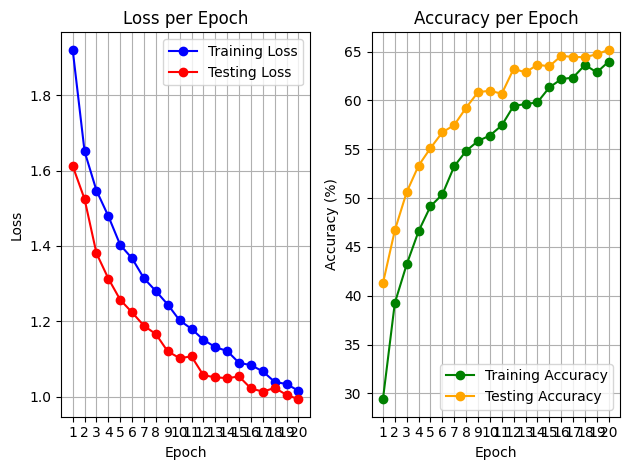

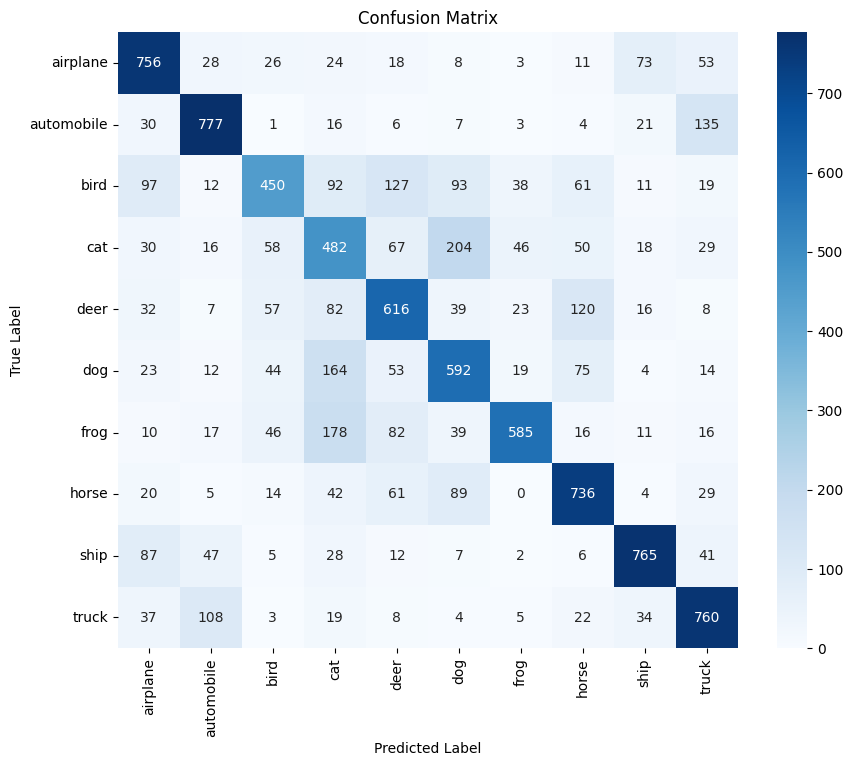

Test Accuracy: 65.19%


In [23]:
# Grafik Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), test_losses, marker='o', label='Testing Loss', color='red')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs + 1))
plt.grid()
plt.legend()

# Grafik Akurasi
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', label='Training Accuracy', color='green')
plt.plot(range(1, num_epochs + 1), test_accuracies, marker='o', label='Testing Accuracy', color='orange')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, num_epochs + 1))
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# Menghitung dan menampilkan confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=trainset.classes, yticklabels=trainset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Menampilkan akurasi testing
print(f'Test Accuracy: {test_accuracy:.2f}%')